This notebook goes through a simple binary classification example, explaining general library functionality and data loading along the way.

We perform binary classification on sex, using structural MRI rois.

# Init Phase

In [1]:
from ABCD_ML.ABCD_ML import ABCD_ML

Using TensorFlow backend.


Replace these values below with your own directory / desired files.

In [2]:
#Define directory with the 2.0_NDA_Data
nda_dr = '/mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/'

#This file stores the name mapping
test_mapping_loc = nda_dr + 'ABCD_Release_ Notes_Data_Release_ 2.0/22. ABCD_Release_2.0_mapping_r.csv'

#We will use as the neuroimaging data just the sMRI data
test_data_loc1 = nda_dr + 'MRI/ABCD sMRI Part 1.csv'
test_data_loc2 = nda_dr + 'MRI/ABCD sMRI Part 2.csv'

#We will load target data (and covariate data) from here
test_target_loc = nda_dr + 'Mental Health/ABCD Parent Demographics Survey.csv'

#We will load stratification data from here
test_strat_loc = nda_dr + 'Other Non-Imaging/ABCD ACS Post Stratification Weights.csv'

We first need to define the class object, which we will use to load load and to train/test different ML models.
There are a few global parameters which we can optionally set when defining this object as well, lets look and see what they are.

In [3]:
#help(ABCD_ML.__init__)

Most of the default parameters are okay for this simple example, but any of them can be changed.

One thing we want to change just to make things easier is setting the default_dataset_type field, as in this example all of the datasets we are loading from are 'explorer' type. This way we won't have to pass that to every loader.

In [4]:
ML = ABCD_ML(default_dataset_type='explorer', existing_log='overwrite')

exp_name = some_exp
log_dr = /home/sage/ABCD_ML/Examples
existing_log = overwrite
verbose = True
exp log dr setup at: /home/sage/ABCD_ML/Examples/some_exp
log file at: /home/sage/ABCD_ML/Examples/some_exp/logs.txt
notebook = True
default subject id col = src_subject_id
eventname = baseline_year_1_arm_1
use default subject ids = True
default dataset type = explorer
default NaN values = ['777', '999']
original targets key col = targets
low memory mode = False
random state = None


ABCD_ML object initialized


# Data Loading Phase

We can continue by optionally loading in a name map, which is simply a dictionary that attempts to rename any column names loaded in, if those column names are a key in the dictionary. This is useful for ABCD data as the default column names might not be useful.

Note this name map and these parameters are for the 'ABCD 2.0 Explorer' formatting. 

In [5]:
ML.Load_Name_Map(loc = test_mapping_loc,
                 source_name_col = "NDAR name",
                 target_name_col = "REDCap name/NDA alias")

Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/ABCD_Release_ Notes_Data_Release_ 2.0/22. ABCD_Release_2.0_mapping_r.csv assumed to be dataset type: explorer
Loaded map file


We can look at what exactly is in this dictionary if we want to confirm we loaded it correctly.
It is loaded as name_map within the ABCD_ML class.

In [6]:
#some_examples = {k: ML.name_map[k] for k in list(ML.name_map)[300:320]}
#some_examples

In [7]:
#help(ML.Load_Exclusions)

For our exclusions we will just use the flipped subjects

Next, we will load in the actual data. Like before we can check what parameters this function wants / can accept

In [8]:
#help(ML.Load_Data)

In [9]:
#ML.Load_Data(loc=[test_data_loc1, test_data_loc2],
#             dataset_type='explorer',
#             filter_outlier_percent=.005, 
#             winsorize_val=.01)           

That ends up being a lot of data dropped just for dropping missing outliers... since we are not in low_memory_mode, we can just clear the data, and reload it. This time we will also load not just the first data loc, but the rest as well - and at the same time - but just providing the locations of both in a list.

In [10]:
#ML.Clear_Data()

In [11]:
ML.Load_Data(loc=[test_data_loc1, test_data_loc2],
             dataset_type='explorer', #This is set as default, but how we would specify it if we wanted to change i
             #filter_outlier_percent=.0005,
             filter_outlier_percent=.01,
             winsorize_val=.001)   

Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/MRI/ABCD sMRI Part 1.csv assumed to be dataset type: explorer
dropped ['abcd_smrip101_id', 'dataset_id', 'smri_visitid'] columns by default  due to dataset type
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/MRI/ABCD sMRI Part 2.csv assumed to be dataset type: explorer
dropped ['abcd_smrip201_id', 'dataset_id'] columns by default  due to dataset type
Dropped 0 columns, per drop_keys argument
Dropped 10 cols for all missing values
Dropped 1233 rows for missing values
Dropped rows with missing data
Filtered data for outliers with value:  0.01
Winsorized data with value:  0.001

The following columns were dropped due to being under the passed unique_val_drop_thresh of:  2
Dropped smri_vol_subcortaseg_wmhypointensitieslh unique vals: 1
Dropped smri_vol_subcortaseg_wmhypointensitiesrh unique vals: 1

loaded shape:  (169, 1184)

Total valid overlapping subjects = 169



These seem okay settings.

Our data for this expiriment should now be loaded. We can check it out:

In [12]:
#ML.data.head()

In [13]:
#ML.data.shape

Great. Now that data is loaded we still need to load targets, and can optionally load covars, strat and exclusions. Lets load our target first, and begin as before by checking out the loading function.

In [14]:
#help(ML.Load_Targets)

Great, lets just load in sex as our target variable.

In [15]:
ML.Load_Targets(loc=test_target_loc,
                col_name='demo_sex_v2',
                data_type='b')

Loading targets!
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/Mental Health/ABCD Parent Demographics Survey.csv assumed to be dataset type: explorer
More than two unique score values found, filtered all but [1. 2.]
Final shape:  (11866, 1)

Total valid overlapping subjects = 169



Show Target distribution:


,Original Value,Count,Frequency
Internal Name,,,
0,1.0,80,0.473373
1,2.0,89,0.526627


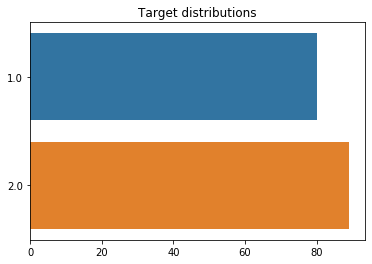

In [16]:
ML.Show_Targets_Dist()

If you read the verbose print out above, you'll notice that it says "More than two unique score values found,filtered all but [1. 2.]" This is because by default when a binary datatype is passed, the dataloader needs to make sure it loads in only two unique values. To solve this when there exists outliers, like in this case, all but the top two unique values by count will be dropped. It will further show which values it has kept, in the case that an error was made, but here 1 and 2 are the correct sex values. If more than two values are desired, the categorical data type should be used.

Let's look and see to make sure everything was loaded correctly.

In [17]:
#ML.targets.head()

We can look into adding covars next. Where co-variates arn't quite treated as typical co-variates, but are values we would like to be able to pass as additional input to the ML model if desired (and input that is treated in a special way, specifically covar input won't be scaled with any data scaler by default). 

In [18]:
#help(ML.Load_Covars)

In [19]:
ML.Load_Covars(loc=test_target_loc,
               col_names = 'demo_ed_v2',
               data_types = 'o',
               standardize = False,
               normalize = False) 

Loading covariates!
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/Mental Health/ABCD Parent Demographics Survey.csv assumed to be dataset type: explorer
load: demo_ed_v2

Total valid overlapping subjects = 169



And check to see it was loaded correctly (and normalized)

In [20]:
#ML.covars.head()

Lastly, we will considering loading different stratification values. These are the values that we can optionally define custom validation / split behavior on. Within this example, we are just going to make sure that all splits preserve subjects with the same family id within the same fold, so lets load family id - after looking as the help function.

In [21]:
#help(ML.Load_Strat)

In [22]:
ML.Load_Strat(loc=test_strat_loc,
              col_names='rel_family_id')

Reading strat/stratification values!
Loading /mnt/sdb2/2.0_ABCD_Data_Explorer/2.0_NDA_Data/Other Non-Imaging/ABCD ACS Post Stratification Weights.csv assumed to be dataset type: explorer

Total valid overlapping subjects = 169

Removing non overlapping subjects


In [23]:
#ML.strat.head()

Great, we now have our data, targets, covars, strat and exclusions loaded (Noting that the minimum requiriments for running an ML expiriment are just data or covars and targets, the rest being optional). The actual length of the script is also not as terrible as it seems, and once loading behavior is confirmed, verbose can even be turned off. To show this, we can re-load everything as above with verbose off. (Commented out, but you get the idea~)

In [24]:
#ML = ABCD_ML.ABCD_ML(verbose = False) # Reloading the ML object itself to reset everything.

#ML.Load_Exclusions(loc=test_exclusion_loc)

#ML.Load_Name_Map(loc = test_mapping_loc,
#                 source_name_col = "NDAR name",
#                 target_name_col = "REDCap name/NDA alias")

#ML.Load_Data(loc=[test_data_loc1, test_data_loc2],
#             dataset_type='explorer',
#             filter_outlier_percent=.0005, 
#             winsorize_val=.01)

#ML.Load_Targets(loc=test_target_loc,
#                col_name='demo_sex_v2',
#                data_type='b')

#ML.Load_Covars(loc=test_target_loc,
#               col_names = 'demo_ed_v2',
#               data_types = 'ordinal',
#               standardize = False,
#               normalize = True)

#ML.Load_Strat(loc=test_strat_loc,
#              col_names='rel_family_id')

#ML.verbose = True

# Validation Phase

Lets move onto defining our validation stratagy (which is again optional, but as stated before for this example we are going to preserve family ids within the same folds), if no explicit validation strategy is defined, then random splits will be used.

In [25]:
#help(ML.Define_Validation_Strategy)

So for group preserving behavior, as we are interested in keep families within the same folds, we supply an argument for groups. Specifically, we use the name of the column loaded within self.strat

In [26]:
ML.Define_Validation_Strategy(groups='rel_family_id')

CV defined with  group preserving  over 168 unique values.


Lastly before we get to modelling, we want to define a global train-test split, so that we can perform model exploration, and parameter tuning ect... on a training set, and leave a left-out testing set to eventually test with out final selected model.

In [27]:
#help(ML.Train_Test_Split)

In [28]:
ML.Train_Test_Split(test_size=.25, #Let be somewhat conservative, and use a size of .25
                    random_state=1)

Final data (w/ target) for modeling loaded shape: (169, 1186)
Performed train/test split, train size: 127 test size:  42


Great - and because we set the validation stratagy to preserve family structure within the folds, we know that no family id is in both the train and test set - for the paranoid we can make sure of this.

In [29]:
#train_ids = set(ML.strat['rel_family_id'].loc[ML.train_subjects])
#test_ids = set(ML.strat['rel_family_id'].loc[ML.test_subjects])

#print('Unique family ids in train: ', len(train_ids))
#print('Unique family ids in test: ', len(test_ids))
#print('Overlap : ', len(train_ids.intersection(test_ids)))

# Modeling Phase

Now we can proceed to modeling.

The main function we use here is Evaluate, we can look at its docstring, but from a very high level, this is the function we use to test different expirimental setups.

In [30]:
#help(ML.Evaluate)

Lets check what different model types we have avaliable for binary first.

In [31]:
#ML.Show_Model_Types(problem_type='binary')

We can also look at different metrics avaliable for binary classification, and different data scalers.

In [32]:
#ML.Show_Metrics(problem_type='binary')

In [33]:
#ML.Show_scalers(show_scaler_help=False, show_default_params=True)

We can also set some default ML params for some of the settings that we will be keeping the same.

In [34]:
#help(ML.Set_Default_ML_Params)

The parameters are mostly the same for setting default params as they are passed to Evaluate or Test. Importantly, by defining defaults, we define the value to be used if no value is passed to a given argument in Evaluate or Test.
Lets set some.

In [35]:
ML.Set_Default_ML_Params(problem_type = 'binary', #This will be staying the same
                         metric = ['macro roc auc', 'f1', 'accuracy'], #Lets set a few
                         scaler = 'standard', #Standard scaling is fine, but this can also be a list
                         n_splits = 2, #For the sake of quick run-time and this example 2 splits, no repeats
                         n_repeats = 1,
                         int_cv = 3,
                         class_weight = 'balanced', 
                         n_jobs = 8,
                         n_iter = 8,
                         random_state = 1)

No default sampler passed, set to None
No default feat selector passed, set to None
No default search type passed, set to None
No default data scaler param ind passed, set to 0
No default sampler param ind passed, set to 0
No default feat selector param ind passed, set to 0
No default data_to_use passed, set to all
No default compute_train_score passed, set to False
No default calc_base_feature_importances passed, set to True
No default calc_shap_feature_importances passed, set to False
No default extra params passed, set to empty dict
Default params set.



Now that we have some default ML params set, all we need to do to run an evaluation is simply:

In [36]:
raw_scores = ML.Evaluate(model_type='rf',
                         sampler='smote',
                         ensemble_type = 'basic ensemble',
                         ensemble_split = .2,
                         n_repeats=1,
                         calc_shap_feature_importances = True,
                         calc_base_feature_importances = True)

Setting default ML verbosity settings!
Note, if the following values are not desired, call self.Set_ML_Verbosity()

Running Evaluate with:
problem_type = binary
model_type = rf
model_type_param_ind = 0
metric = ['macro roc auc', 'f1', 'accuracy']
scaler = standard
scaler_param_ind = 0
sampler = smote
sampler_param_ind = 0
feat_selector = None
n_splits = 2
n_repeats = 1
search_type = None
class_weight = balanced
n_jobs = 8
data_to_use = all
compute_train_score = False
random_state = 1
calc_base_feature_importances = True
calc_shap_feature_importances = True
extra_params = {}

Saving scores and settings with unique name: rf




Validation Scores
_________________
Metric:  macro roc auc
Mean Validation score:  0.6369450898862663
Std in Validation score:  0.0012902042313807094

Metric:  f1
Mean Validation score:  0.6741787624140566
Std in Validation score:  0.027119938884644812

Metric:  accuracy
Mean Validation score:  0.6299603174603174
Std in Validation score:  0.004960317460317443



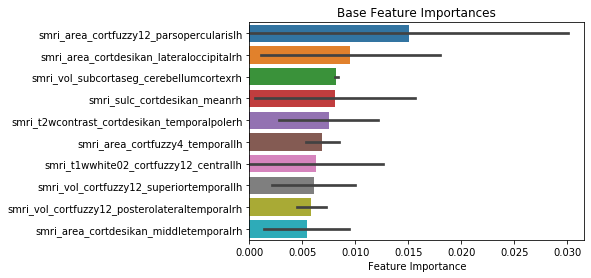

In [37]:
ML.Plot_Base_Feat_Importances(top_n = 10)

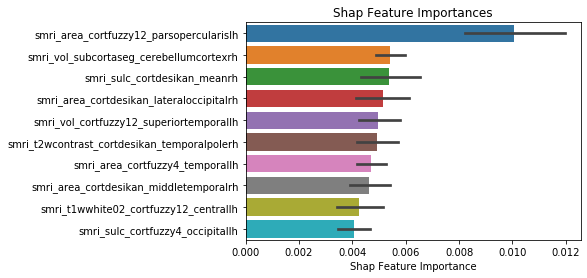

In [38]:
ML.Plot_Shap_Feat_Importances()

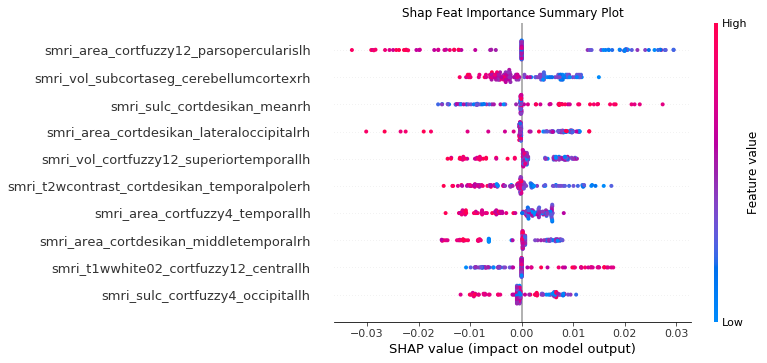

In [39]:
ML.Plot_Shap_Summary()

In [40]:
vcbcvb

NameError: name 'vcbcvb' is not defined

Lets try with multiple data scalers now, just to show off that functionality, and still just the logistic regression.

In [ ]:
raw_scores = ML.Evaluate(model_type='logistic',
             scaler = ['robust', 'minmax'])

The robust scaler and minmax scaler seem to help a bit, so hey lets set that as our new default... just for fun.

Note when setting a new param, you do not need to repass in everything you are not changing!

In [ ]:
ML.Set_Default_ML_Params(scaler = ['robust', 'minmax'])

# Let make just take a look at the new default params, to make sure it is as expected
ML.default_ML_params

We can run a more complicated classifier, in particular, let's
try the light gradient boosting machine (LGBM) classifier, with a random search for parameters.
Note: The ' rs' at the end of the str model indicator is a special key for selecting the random parameter search option.

In [ ]:
raw_scores = ML.Evaluate(model_type='lgbm classifier',
                         search_type='random',
                         model_type_param_ind=1,
                         n_iter=2)

Interesting, the basic logistic regression seems to perform better then the more complex gradient boosting. One thing to note though is that we only tested 8 random sets of hyperparamers, what if we tried exploring a larger number? (This might take a while, especially if you are not running this on a powerful computer).

In [ ]:
raw_scores = ML.Evaluate(model_type='lgbm classifier rs',
                         n_iter=100)

That is still not all that big a boost from just a logistic regression.
We can still explore some other linear classifiers though.

In [ ]:
raw_scores = ML.Evaluate(model_type='ridge logistic rs')

In [ ]:
raw_scores = ML.Evaluate(model_type='knn classifier gs')

In [ ]:
raw_scores = ML.Evaluate(model_type='gaussian nb')

In [ ]:
#This is a gaussian process classifier
raw_scores = ML.Evaluate(model_type='gp')

In [ ]:
raw_scores = ML.Evaluate(model_type='elastic net logistic rs')

You could easily continue with the model exploration portion, but for this example, lets say we have explored enough.

# Testing Phase

In [ ]:
ML.Test(model_type ='ridge logistic rs')